# MiSDEED overview

Welcome to the MiSDEED tutorial. MiSDEED is a synthetic data generator that relies on the generalized Lotka-Volterra equations. This tutorial will go through a few short examples of how MiSDEED can be used as a Python package:
* Generating a single timecourse with an intervention
* Generating 20 timecourses from similar communities
* Generating case-control timecourses
* Inferring gLV parameters from empirical pilot datasets

First we need to get our imports sorted out. MiSDEED is available on PyPI at https://pypi.org/project/MiSDEED and on Github at https://github.com/pchlenski/MiSDEED.

In [1]:
!pip install misdeed

In [2]:
from misdeed.OmicsGenerator import OmicsGenerator
from misdeed.visualization import plot_timecourse, plot_pca
from misdeed.inference import infer_glv_params

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
from matplotlib import cm

import numpy as np
np.random.seed(10)

# Initialize generator with intervention

First we create a basic generator with the following parameters:
* 10 days, 50 time points total
* Metagenomics and metabolomics measurements, 15 dimensions each
* Intervention affects metagenomic growth rates at day 5

In [3]:
# Set global variables
TIME_POINTS = 1000
TIME_STEP = 1e-2 # Update abundances 100x/day
NODE_NAMES = ['mgx', 'mbx'] # 2 nodes named 'mgx' and 'mbx'
NODE_SIZES = [15, 15] # Set interaction matrices and growth rates randomly
INTERVENTION_START = int(TIME_POINTS / 2) # Start intervention halfway through
INTERVENTION_END = TIME_POINTS # End intervention at the end
DOWNSAMPLE = 20 # Keep every 20-th time point (Results in 50 time points covering 10 days)

# Generator variables
NOISE_VAR = .01
N_TRAJECTORIES = 20 

# Case-control variables
N_PATIENTS = 100
CASE_CONTROL = .75
EFFECT_SIZE = 1

# Get names
NAMES_MGX = [f"mgx_{i}" for i in range(NODE_SIZES[0])]
NAMES_MBX = [f"mbx_{i}" for i in range(NODE_SIZES[1])]

In [4]:
# Initialize generator:
gen = OmicsGenerator(
    time_points=TIME_POINTS,
    node_names=NODE_NAMES,
    node_sizes=NODE_SIZES,
    init_full=True
)

# Add intervention:
gen.add_intervention(
    name='int1', # intervention name
    node_name='mgx', # apply to 'mgx' node
    vector=10*np.random.rand(15), # set intervention response vector randomly
    start=INTERVENTION_START, # start at t=50
    end=INTERVENTION_END # go to end
)

Node 'mgx' initialized
Node 'mbx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:15    0:15
Interaction 'mgx->mbx' added
set m:(mgx)->(mbx):   0:15    15:30
Interaction 'mbx->mgx' added
set m:(mbx)->(mgx):   15:30    0:15
Interaction 'mbx->mbx' added
set m:(mbx)->(mbx):   15:30    15:30
Added x0 vector to node mgx
Added growth rates to node mgx
Added x0 vector to node mbx
Added growth rates to node mbx
Initialized
Intervention 'int1' added


# Single timecourse

Here we plot a single timecourse from the generator as a stacked barplot using the `plot_timecourse()` convenience function

Text(0.5, 1.0, 'Metagenomic relative abundance time course, single sample')

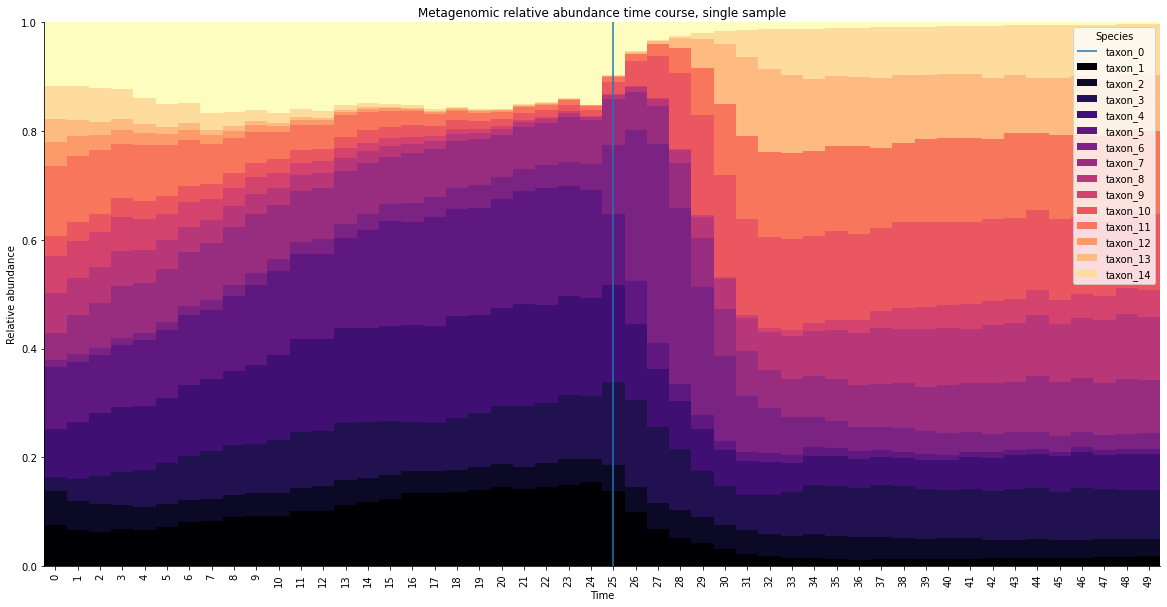

In [5]:
# Run generator and plot:
z1, x1, y1 = gen.generate(
    dt=TIME_STEP, 
    noise_var=NOISE_VAR, 
    downsample=DOWNSAMPLE
)
plot_timecourse(df=y1['mgx'], figsize=(20,10))
plt.vlines(INTERVENTION_START / DOWNSAMPLE, 0, 1)

plt.legend(title="Species", labels=[f"taxon_{i}" for i in range(NODE_SIZES[0])])
plt.xlabel("Time")
plt.ylabel("Relative abundance")
plt.title("Metagenomic relative abundance time course, single sample")

**NB:** The blue line at *t*=25 indicates when the intervention is applied. You can see that the growth rates immediately shift and eventually seek a new equilibrium. This is typical for dynamical systems govered by generalized Lotka-Volterra equations under perturbations.

# Multiple timecourses

Here we observe the behavior of the generator across several individuals. We assume the following:
* Time courses have same parameters as before, including growth rates and interaction matrices
* The first time point is sampled from a log-normal distribution
* 20 individuals are enrolled in the study

We use the convenience function `plot_pca()` to view PCA trajectories of multiple timecourses in a single graph.

Text(0.5, 1.0, 'Metagenomic trajectories, 20 samples')

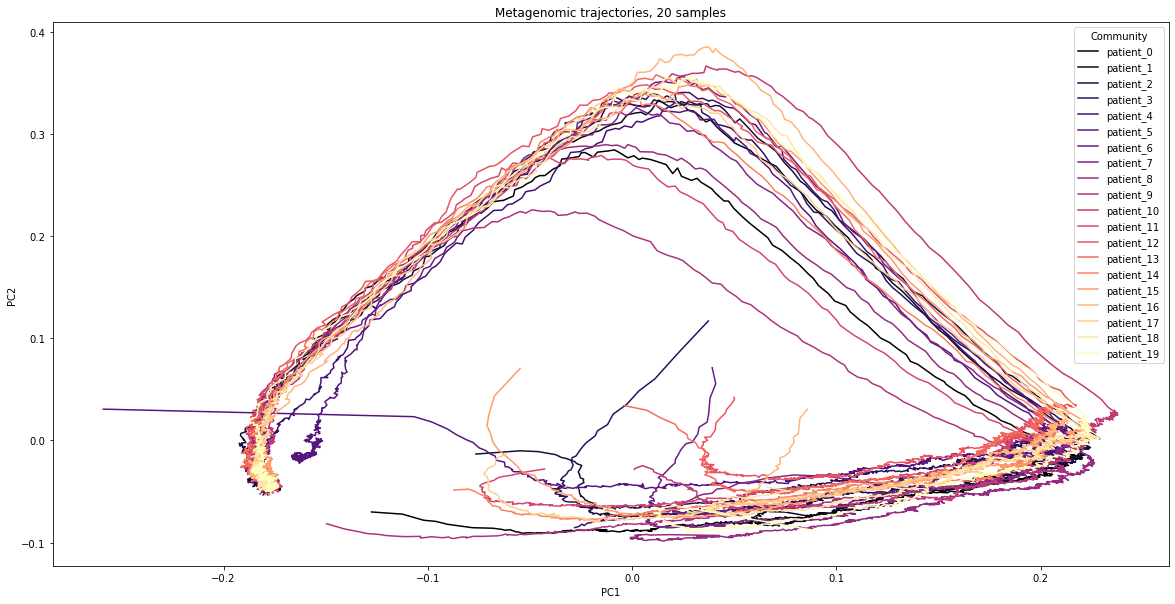

In [6]:
# Run multi-generator and plot:
z2, x2, y2 = gen.generate_multiple(n=N_TRAJECTORIES, noise_var=NOISE_VAR)
plot_pca(
    trajectories=[y2], 
    node_name='mgx'
)

# Labels
plt.legend(title="Community", labels=[f"patient_{i}" for i in range(N_TRAJECTORIES)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Metagenomic trajectories, 20 samples")

**NB:** Note how the trajectories converge to an equilibrium in the bottom-right quadrant of the graph, and then on application of the intervention they follow a similar trajectory up and back down into the bottom-left quadrant. This induced difference of attractors is the basis for the case-control simulation used by MiSDEED:

# Case-control

We further assume the following things about our case-control system:
* There are 100 patients enrolled in the study: 75 cases and 25 controls
* The effect size is 1

Intervention 'CASE' added


Text(0.5, 1.0, 'Trajectory endpoint PCA, cases vs. controls')

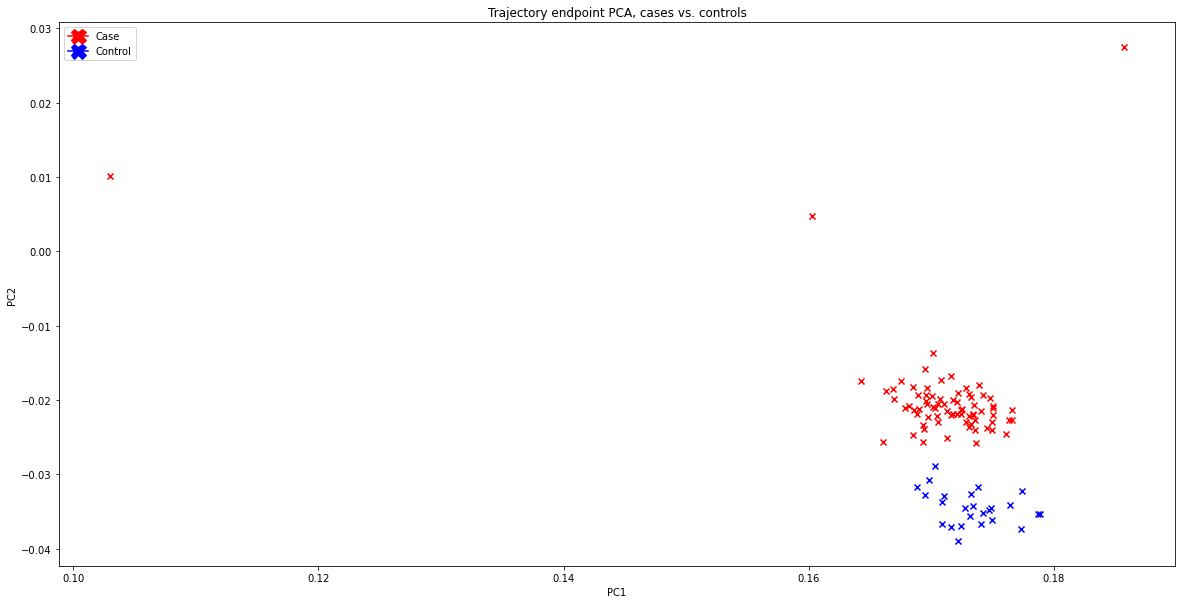

In [7]:
# Run case-control and plot:
z3_control, x3_control, y3_control, z3_case, x3_case, y3_case = gen.case_control(
    participants=N_PATIENTS,
    case_frac=CASE_CONTROL,
    node_name='mgx',
    effect_size=EFFECT_SIZE,
    dt=TIME_STEP,
    noise_var=NOISE_VAR
)
plot_pca(
    trajectories=[y3_control, y3_case], 
    node_name='mgx',
    colors=["blue", "red"],
    plot_trajectories=False
)

# Labels
l1 = plt.Line2D([0], [0], color="red", marker="X", markersize=15, label="Case")
l2 = plt.Line2D([0], [0], color="blue", marker="X", markersize=15, label="Control")
plt.legend(handles=[l1, l2])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Trajectory endpoint PCA, cases vs. controls")

# Using learned interaction matrices

This section is more complicated than the others. It is meant to show how the convenience function `infer_glv_params()` can be used to determine growth rates, interaction matrices, and intervention response vectors. The new parameters for the system are simpler, to facilitate better inference and easier visualization of results:
* Single system consisting of 8-clade metagenomic measurements
* 100 time points spanning a single day
* Intervention applied halfway through timecourse

The process for creating this graph is as follows:
1. Time course A is generated using random gLV parameters.
2. Time course A is plotted (line graph)
3. Interaction matrix, growth rates, and intervention responses are inferred from time course A using `infer_glv_params()`
4. Time course B is generated using inferred gLV parameters.
5. Time course B is plotted (scatterplot) on top of time course A.

Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:8    0:8
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Intervention 'int1' added
Node 'mgx' initialized
Initialized
Interaction 'M' added
Intervention 'int1' added
Added growth rates to node mgx
Added x0 vector to node mgx


Text(0.5, 1.0, 'Metagenomic relative abundance time course, real vs. inferred')

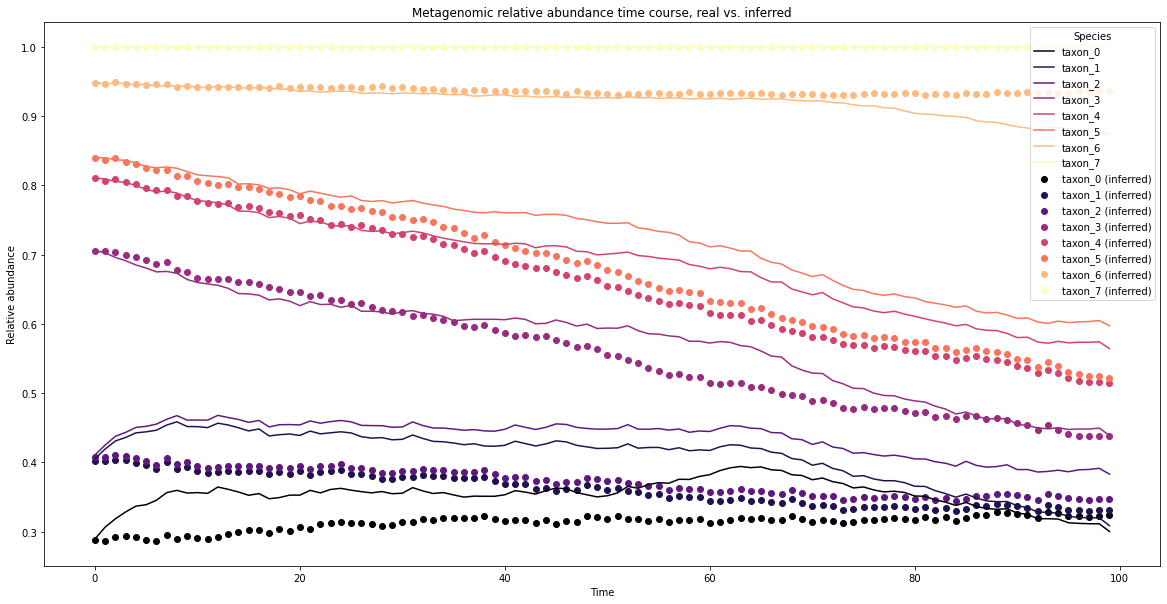

In [8]:
# New global variables:
INFER_NODE_NAMES = ['mgx']
NODE_SIZE = 8
INFER_NODE_SIZES = [NODE_SIZE]
TIME_POINTS = 100
INTERVENTION_START = 50

# L1 regularization terms for gLV inference:
INTERACTION_REG = 100
GROWTH_REG = 1
INTERVENTION_REG = 100

# Run case-control and plot:
gen4 = OmicsGenerator(
    time_points=TIME_POINTS,
    node_names=INFER_NODE_NAMES,
    node_sizes=INFER_NODE_SIZES,
    init_full=True # set interaction matrices and growth rates randomly
)

# Add intervention:
gen4.add_intervention(
    name='int1', # intervention name
    node_name='mgx', # apply to 'mgx' node
    vector=10*np.random.rand(NODE_SIZE), # set intervention response vector randomly
    start=INTERVENTION_START, # start at t=50
    end=INTERVENTION_END # go to end
)

# Generate training data
z4, x4, y4 = gen4.generate(dt=TIME_STEP)

# Infer gLV parameters
M, u, E = infer_glv_params(
    abundances=z4['mgx'], # use (latent) absolute abundances
    interventions=gen4.get('int1').U, # assume intervention indicator is known
    interaction_reg=INTERACTION_REG, # L1 penalty for interaction matrix
    growth_reg=GROWTH_REG, # L1 penalty for growth rates
    intervention_reg=INTERVENTION_REG, # L1 penalty for intervention responses
    dt=TIME_STEP # same time-step as generator
)

# Build inferred generator
gen4_inferred = OmicsGenerator(
    time_points=TIME_POINTS,
    node_names=INFER_NODE_NAMES, 
    node_sizes=INFER_NODE_SIZES
)
gen4_inferred.add_interaction(
    name='M',
    outbound_node_name='mgx',
    inbound_node_name='mgx',
    matrix=M
)
gen4_inferred.add_intervention(
    name='int1',
    node_name='mgx',
    vector=E.reshape(-1),
    start=INTERVENTION_START,
    end=INTERVENTION_END
)
gen4_inferred.set_initial_value(
    node_name='mgx',
    values=u.reshape(-1),
    growth_rate=True
)
gen4_inferred.set_initial_value(
    node_name='mgx',
    values=y4['mgx'][0],
)

z4_inferred, x4_inferred, y4_inferred = gen4_inferred.generate(dt=TIME_STEP)

# Plot both trajectories
colors = cm.get_cmap('magma', NODE_SIZE)(range(NODE_SIZE))
for i in range(NODE_SIZE):
    plt.scatter(np.arange(TIME_POINTS), np.cumsum(y4_inferred['mgx'], axis=1)[:,i], color=colors[i])
    plt.plot(np.cumsum(y4['mgx'], axis=1)[:,i], c=colors[i])
    
# Labels
l1 = [f"taxon_{i}" for i in range(NODE_SIZE)]
l2 = [f"taxon_{i} (inferred)" for i in range(NODE_SIZE)]
plt.legend(title="Species", labels=[*l1, *l2])
plt.xlabel("Time")
plt.ylabel("Relative abundance")
plt.title("Metagenomic relative abundance time course, real vs. inferred")

Here you can see that even under idealized conditions, unconstrained inference of gLV parameters can have only modest fidelity to the data. This is realistic for inferred gLV parameters. 